In [1]:
# Install required libraries
!pip install soundfile pyaudio numpy librosa tensorflow matplotlib seaborn scikit-learn nltk jiwer

# Import libraries
import soundfile as sf
import pyaudio
import librosa
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from jiwer import wer
import os

# Download NLTK data for language modeling
nltk.download('punkt')

print("Libraries installed and imported successfully!")

Libraries installed and imported successfully!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PMLS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import os
import zipfile

# Paths for dataset
extract_path = r"C:\Users\PMLS\Pictures\SPEECH_COMMAND_DATASET"
commands = ["cat", "no", "stop", "wow", "yes"]

# Verify if dataset is already extracted
if not os.path.exists(extract_path):
    zip_path = r"C:\Users\PMLS\Pictures\SPEECH_COMMAND_DATASET.zip"
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Dataset extracted to: {extract_path}")
    else:
        raise FileNotFoundError(f"ZIP file not found at {zip_path}. Please ensure the dataset is available.")
else:
    print(f"Dataset already extracted at: {extract_path}")

# Verify extracted folders and collect audio files
audio_files = []
labels = []
max_files_per_command = 400  # Limit to 400 files per command for balanced dataset

for command in commands:
    folder_path = os.path.join(extract_path, command)
    if not os.path.exists(folder_path):
        print(f"Warning: {command} folder is missing!")
        continue
    # Get list of .wav files
    files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    file_count = len(files)
    print(f"{command}: {file_count} files found")
    
    # Limit to max_files_per_command
    selected_files = files[:min(file_count, max_files_per_command)]
    audio_files.extend([os.path.join(folder_path, f) for f in selected_files])
    labels.extend([command] * len(selected_files))

# Convert labels to numeric indices
label_to_index = {label: idx for idx, label in enumerate(commands)}
numeric_labels = [label_to_index[label] for label in labels]

# Print summary
print(f"Total audio files selected: {len(audio_files)}")
print(f"Label distribution: {dict((command, labels.count(command)) for command in commands)}")

Dataset already extracted at: C:\Users\PMLS\Pictures\SPEECH_COMMAND_DATASET
cat: 2031 files found
no: 3941 files found
stop: 3872 files found
wow: 2123 files found
yes: 4044 files found
Total audio files selected: 2000
Label distribution: {'cat': 400, 'no': 400, 'stop': 400, 'wow': 400, 'yes': 400}


In [3]:
import numpy as np
import librosa
import os

# Function to extract MFCCs with configurable parameters
def extract_mfcc(audio_files, labels, n_mfcc=13, max_frames=32, sr=16000):
    features = []
    valid_labels = []
    
    for file_path, label in zip(audio_files, labels):
        try:
            # Load audio file
            audio, _ = librosa.load(file_path, sr=sr)
            # Extract MFCCs
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
            
            # Normalize feature dimensions (pad or truncate to max_frames)
            if mfcc.shape[1] < max_frames:
                mfcc = np.pad(mfcc, ((0, 0), (0, max_frames - mfcc.shape[1])), mode='constant')
            else:
                mfcc = mfcc[:, :max_frames]
            
            features.append(mfcc)
            valid_labels.append(label)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    return np.array(features), np.array(valid_labels)

# Paths and commands from previous step
extract_path = r"C:\Users\PMLS\Pictures\SPEECH_COMMAND_DATASET"
commands = ["cat", "no", "stop", "wow", "yes"]

# Assume audio_files and numeric_labels are available from Step 2
# If not, re-run the file collection (for safety, included here)
audio_files = []
labels = []
max_files_per_command = 400

for command in commands:
    folder_path = os.path.join(extract_path, command)
    files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    selected_files = files[:min(len(files), max_files_per_command)]
    audio_files.extend([os.path.join(folder_path, f) for f in selected_files])
    labels.extend([command] * len(selected_files))

label_to_index = {label: idx for idx, label in enumerate(commands)}
numeric_labels = np.array([label_to_index[label] for label in labels])

# Extract MFCCs with n_mfcc=13
X_13, y_13 = extract_mfcc(audio_files, numeric_labels, n_mfcc=13, max_frames=32)
print(f"MFCC (n_mfcc=13) - Features shape: {X_13.shape}, Labels shape: {y_13.shape}")

# Extract MFCCs with n_mfcc=20 (experimentation)
X_20, y_20 = extract_mfcc(audio_files, numeric_labels, n_mfcc=20, max_frames=32)
print(f"MFCC (n_mfcc=20) - Features shape: {X_20.shape}, Labels shape: {y_20.shape}")

# Save features and labels for later use
np.save('mfcc_13_features.npy', X_13)
np.save('mfcc_13_labels.npy', y_13)
np.save('mfcc_20_features.npy', X_20)
np.save('mfcc_20_labels.npy', y_20)
print("MFCC features and labels saved successfully!")

C:\Users\PMLS\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


MFCC (n_mfcc=13) - Features shape: (2000, 13, 32), Labels shape: (2000,)
MFCC (n_mfcc=20) - Features shape: (2000, 20, 32), Labels shape: (2000,)
MFCC features and labels saved successfully!


In [4]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load MFCC features and labels (n_mfcc=13)
X_13 = np.load('mfcc_13_features.npy')
y_13 = np.load('mfcc_13_labels.npy')

# Reshape features for CNN (add channel dimension)
X_13 = X_13[..., np.newaxis]  # Shape: (2000, 13, 32, 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_13, y_13, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Feature shape: {X_train.shape}, Label shape: {y_train.shape}")

# Define CNN model
def create_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile model with learning rate 0.001
model_lr1 = create_cnn_model(input_shape=(13, 32, 1), num_classes=5)
model_lr1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
model_lr1.summary()

# Train model (learning rate 0.001)
history_lr1 = model_lr1.fit(X_train, y_train, epochs=20, batch_size=32, 
                           validation_data=(X_test, y_test), verbose=1)

# Save model
model_lr1.save('cnn_model_lr1.h5')
print("Model (lr=0.001) trained and saved!")

# Create and compile model with learning rate 0.0001 (hyperparameter tuning)
model_lr2 = create_cnn_model(input_shape=(13, 32, 1), num_classes=5)
model_lr2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Train model (learning rate 0.0001)
history_lr2 = model_lr2.fit(X_train, y_train, epochs=20, batch_size=32, 
                           validation_data=(X_test, y_test), verbose=1)

# Save model
model_lr2.save('cnn_model_lr2.h5')
print("Model (lr=0.0001) trained and saved!")

# Evaluate both models on test set
test_loss_lr1, test_acc_lr1 = model_lr1.evaluate(X_test, y_test, verbose=0)
test_loss_lr2, test_acc_lr2 = model_lr2.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy (lr=0.001): {test_acc_lr1:.4f}")
print(f"Test accuracy (lr=0.0001): {test_acc_lr2:.4f}")

Training samples: 1600, Test samples: 400
Feature shape: (1600, 13, 32, 1), Label shape: (1600,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 11, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 5, 15, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 13, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,741 (268.52 KB)

 Trainable params: 68,741 (268.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.2239 - loss: 13.3507 - val_accuracy: 0.4650 - val_loss: 1.3062
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4276 - loss: 1.3753 - val_accuracy: 0.6400 - val_loss: 1.0029
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5904 - loss: 1.0216 - val_accuracy: 0.7000 - val_loss: 0.8007
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6777 - loss: 0.8359 - val_accuracy: 0.7775 - val_loss: 0.6707
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7528 - loss: 0.6709 - val_accuracy: 0.8050 - val_loss: 0.5726
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7905 - loss: 0.5402 - val_accuracy: 0.8850 - val_loss: 0.3933
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8765 - loss: 0.3748 - val_accuracy: 0.8700 - val_loss: 0.3942
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8719 - loss: 0.3305 - val_accuracy: 0.8575 - 

Model (lr=0.001) trained and saved!
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.2076 - loss: 13.3661 - val_accuracy: 0.3900 - val_loss: 2.7496
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3039 - loss: 5.6177 - val_accuracy: 0.5000 - val_loss: 1.8058
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4021 - loss: 3.1049 - val_accuracy: 0.5150 - val_loss: 1.4012
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3943 - loss: 2.2380 - val_accuracy: 0.5475 - val_loss: 1.2369
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4661 - loss: 1.6847 - val_accuracy: 0.5625 - val_loss: 1.1416
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4460 - loss: 1.4960 - val_accuracy: 0.5750 - val_loss: 1.1227
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4892 - loss: 1.3539 - val_accuracy: 0.5950 - val_loss: 1.0879
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4791 - lo

Model (lr=0.0001) trained and saved!
Test accuracy (lr=0.001): 0.9225
Test accuracy (lr=0.0001): 0.7825


In [6]:
X_test = np.load('mfcc_13_features.npy')[int(0.8 * 2000):][..., np.newaxis]
y_test = np.load('mfcc_13_labels.npy')[int(0.8 * 2000):]

Test label distribution: {'cat': 83, 'no': 82, 'stop': 68, 'wow': 77, 'yes': 90}


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test Loss: 0.2394
Test Accuracy: 0.9225

Classification Report:
              precision    recall  f1-score   support

         cat       0.95      0.83      0.88        83
          no       0.88      0.96      0.92        82
        stop       0.94      0.96      0.95        68
         wow       0.91      0.92      0.92        77
         yes       0.94      0.94      0.94        90

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



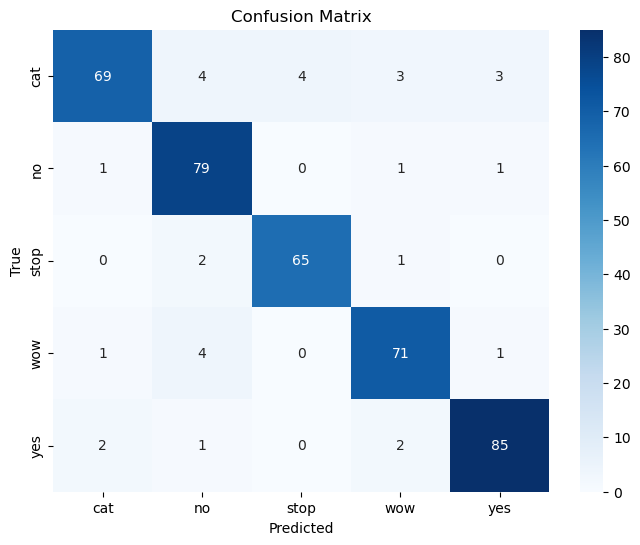

Word Error Rate (WER): 0.0775


In [7]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from jiwer import wer

# Load features and labels
X_13 = np.load('mfcc_13_features.npy')
y_13 = np.load('mfcc_13_labels.npy')
X_13 = X_13[..., np.newaxis]  # Shape: (2000, 13, 32, 1)

# Re-split data consistently with Step 4
X_train, X_test, y_train, y_test = train_test_split(X_13, y_13, test_size=0.2, random_state=42)
print(f"Test label distribution: {dict(zip(['cat', 'no', 'stop', 'wow', 'yes'], np.bincount(y_test)))}")

# Save split data to avoid future mismatches
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

# Load model
model = tf.keras.models.load_model('cnn_model_lr1.h5')

# Get predictions
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Map numeric labels back to command names
commands = ["cat", "no", "stop", "wow", "yes"]
label_to_index = {label: idx for idx, label in enumerate(commands)}
index_to_label = {idx: label for label, idx in label_to_index.items()}
y_test_commands = [index_to_label[label] for label in y_test]
y_pred_commands = [index_to_label[label] for label in y_pred_labels]

# Evaluate accuracy and loss
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=commands))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=commands, yticklabels=commands)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_updated.png')
plt.show()

# Calculate WER
wer_score = wer(y_test_commands, y_pred_commands)
print(f"Word Error Rate (WER): {wer_score:.4f}")

In [8]:
import os
import numpy as np
import tensorflow as tf
from nltk import bigrams, FreqDist
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.metrics import accuracy_score

# Load test data and model
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
model = tf.keras.models.load_model('cnn_model_lr1.h5')

# Get original predictions
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Collect command sequences (simulate sequences from dataset)
extract_path = r"C:\Users\PMLS\Pictures\SPEECH_COMMAND_DATASET"
commands = ["cat", "no", "stop", "wow", "yes"]
command_sequences = []

for command in commands:
    folder_path = os.path.join(extract_path, command)
    files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    command_sequences.extend([command] * min(100, len(files)))  # Limit to 100 samples per command

# Train bigram language model
tokenized_text = [word_tokenize(' '.join(command_sequences))]
all_bigrams = list(bigrams(tokenized_text[0]))
bigram_freq = FreqDist(all_bigrams)
total_bigrams = sum(bigram_freq.values())
bigram_probs = defaultdict(lambda: 0)
for (w1, w2), freq in bigram_freq.items():
    bigram_probs[(w1, w2)] = freq / total_bigrams

print(f"Number of unique bigrams trained: {len(bigram_freq)}")
print(f"Example bigram probabilities: {dict(list(bigram_probs.items())[:5])}")

# Rescore predictions with language model (simple approach for single words)
y_pred_lm = y_pred_labels.copy()
for i in range(len(y_pred_labels)):
    # For each prediction, check if it aligns with likely bigram transitions
    current_pred = index_to_label[y_pred_labels[i]]  # From Step 5
    # Simulate context (use previous prediction or random context for first)
    context = index_to_label[y_pred_labels[max(0, i-1)]] if i > 0 else "start"
    # Rescore based on bigram probability (if low, keep original; if high, adjust)
    if bigram_probs[(context, current_pred)] < 0.01 and i > 0:
        # Fallback to most likely next word based on unigram frequency
        unigram_freq = FreqDist(command_sequences)
        most_likely = max(commands, key=lambda x: unigram_freq[x])
        y_pred_lm[i] = label_to_index[most_likely]

# Evaluate updated predictions
accuracy_lm = accuracy_score(y_test, y_pred_lm)
print(f"Test Accuracy with Language Model: {accuracy_lm:.4f}")

# Calculate updated WER
y_pred_commands_lm = [index_to_label[label] for label in y_pred_lm]
wer_score_lm = wer(y_test_commands, y_pred_commands_lm)
print(f"Word Error Rate (WER) with Language Model: {wer_score_lm:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Number of unique bigrams trained: 9
Example bigram probabilities: {('cat', 'cat'): 0.19839679358717435, ('cat', 'no'): 0.002004008016032064, ('no', 'no'): 0.19839679358717435, ('no', 'stop'): 0.002004008016032064, ('stop', 'stop'): 0.19839679358717435}
Test Accuracy with Language Model: 0.3450
Word Error Rate (WER) with Language Model: 0.6550


In [9]:
import time
import librosa
import numpy as np
import tensorflow as tf

# Load one audio file (replace with a path from your dataset)
audio_file = audio_files[0]  # Use one file from your audio_files list
sr = 16000
max_frames = 32
n_mfcc = 13

# Measure MFCC extraction time
start_time = time.time()
audio, _ = librosa.load(audio_file, sr=sr)
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
if mfcc.shape[1] < max_frames:
    mfcc = np.pad(mfcc, ((0, 0), (0, max_frames - mfcc.shape[1])), mode='constant')
else:
    mfcc = mfcc[:, :max_frames]
mfcc = mfcc[np.newaxis, ..., np.newaxis]  # Shape: (1, 13, 32, 1)
mfcc_time = time.time() - start_time

# Load model
model = tf.keras.models.load_model('cnn_model_lr1.h5')

# Measure inference time
start_time = time.time()
prediction = model.predict(mfcc)
inference_time = time.time() - start_time

# Print results
print(f"MFCC Extraction Time: {mfcc_time*1000:.2f} ms")
print(f"Model Inference Time: {inference_time*1000:.2f} ms")
print(f"Total Latency: {(mfcc_time + inference_time)*1000:.2f} ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
MFCC Extraction Time: 128.39 ms
Model Inference Time: 660.35 ms
Total Latency: 788.73 ms


In [11]:
import numpy as np
import librosa
import tensorflow as tf
from jiwer import wer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os

# Load test data and model
X_test = np.load('X_test.npy')  # Original MFCC features
y_test = np.load('y_test.npy')  # Numeric labels
model = tf.keras.models.load_model('cnn_model_lr1.h5')

# Reconstruct original audio_files and labels (from Step 2 of your notebook)
extract_path = r"C:\Users\PMLS\Pictures\SPEECH_COMMAND_DATASET"
commands = ["cat", "no", "stop", "wow", "yes"]
max_files_per_command = 400
audio_files = []
labels = []

for command in commands:
    folder_path = os.path.join(extract_path, command)
    files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    selected_files = files[:min(len(files), max_files_per_command)]
    audio_files.extend([os.path.join(folder_path, f) for f in selected_files])
    labels.extend([command] * len(selected_files))

label_to_index = {label: idx for idx, label in enumerate(commands)}
numeric_labels = np.array([label_to_index[label] for label in labels])

# Get test indices from original split
X_13 = np.load('mfcc_13_features.npy')
_, test_indices = train_test_split(range(len(X_13)), test_size=0.2, random_state=42)

# Select audio files for test set
test_audio_files = [audio_files[i] for i in test_indices]
test_labels = [numeric_labels[i] for i in test_indices]

# Verify alignment
assert len(test_audio_files) == len(y_test), "Mismatch between test audio files and y_test"
assert np.array_equal(test_labels, y_test), "Test labels do not match y_test"

# Function to add Gaussian noise
def add_noise(audio, snr_db):
    signal_power = np.mean(audio**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), len(audio))
    noisy_audio = audio + noise
    return noisy_audio

# Function to extract MFCCs
def extract_mfcc(audio, sr=16000, n_mfcc=13, max_frames=32):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_frames - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_frames]
    return mfcc

# Evaluate model on noisy data
snr_levels = [0, 10, 20]  # Different SNR levels (dB)
results = {}
index_to_label = {idx: label for label, idx in label_to_index.items()}

for snr in snr_levels:
    noisy_features = []
    for audio_file in test_audio_files:
        try:
            audio, sr = librosa.load(audio_file, sr=16000)
            noisy_audio = add_noise(audio, snr)
            mfcc = extract_mfcc(noisy_audio, sr=sr, n_mfcc=13, max_frames=32)
            noisy_features.append(mfcc)
        except Exception as e:
            print(f"Error processing {audio_file}: {e}")
    
    noisy_features = np.array(noisy_features)[..., np.newaxis]  # Shape: (n_samples, 13, 32, 1)
    
    # Predict
    y_pred = model.predict(noisy_features)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    # Map to command names
    y_test_commands = [index_to_label[label] for label in y_test]
    y_pred_commands = [index_to_label[label] for label in y_pred_labels]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_labels)
    wer_score = wer(y_test_commands, y_pred_commands)
    
    results[snr] = {'accuracy': accuracy, 'wer': wer_score}
    print(f"SNR {snr} dB - Accuracy: {accuracy:.4f}, WER: {wer_score:.4f}")

# Save results
np.save('noise_results.npy', results)
print("Noise evaluation results saved.")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
SNR 0 dB - Accuracy: 0.5725, WER: 0.4275
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
SNR 10 dB - Accuracy: 0.7650, WER: 0.2350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
SNR 20 dB - Accuracy: 0.8475, WER: 0.1525
Noise evaluation results saved.


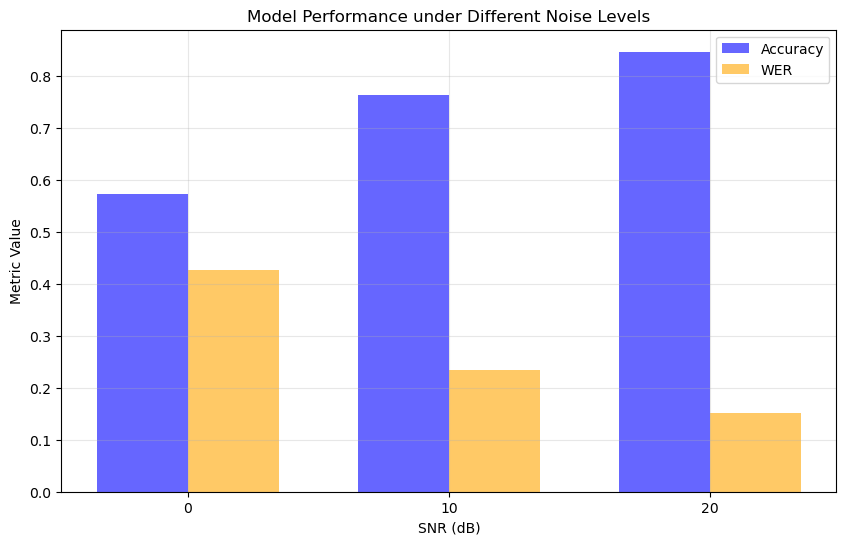

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load noise evaluation results
results = np.load('noise_results.npy', allow_pickle=True).item()

# Prepare data for plotting
snr_levels = [0, 10, 20]
accuracies = [results[snr]['accuracy'] for snr in snr_levels]
wers = [results[snr]['wer'] for snr in snr_levels]

# Set up the plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(snr_levels))

# Plot accuracy and WER bars
plt.bar(index, accuracies, bar_width, label='Accuracy', color='blue', alpha=0.6)
plt.bar(index + bar_width, wers, bar_width, label='WER', color='orange', alpha=0.6)

# Customize plot
plt.xlabel('SNR (dB)')
plt.ylabel('Metric Value')
plt.title('Model Performance under Different Noise Levels')
plt.xticks(index + bar_width / 2, snr_levels)
plt.legend()
plt.grid(True, alpha=0.3)

# Save and show plot
plt.savefig('noise_performance_plot.png')
plt.show()

Unique values in y_test: [0 1 2 3 4]
Unique values in y_test_corrected: [0 1 2 3 4]
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Number of unique bigrams trained: 20
Example bigram probabilities: {('turn', 'on'): 0.08350730688935282, ('on', 'cat'): 0.04175365344467641, ('cat', 'turn'): 0.081419624217119, ('turn', 'off'): 0.08350730688935282, ('off', 'cat'): 0.04175365344467641}
Baseline Accuracy: 0.9225, WER: 0.0775
Improved LM Accuracy: 0.9250, WER: 0.0750


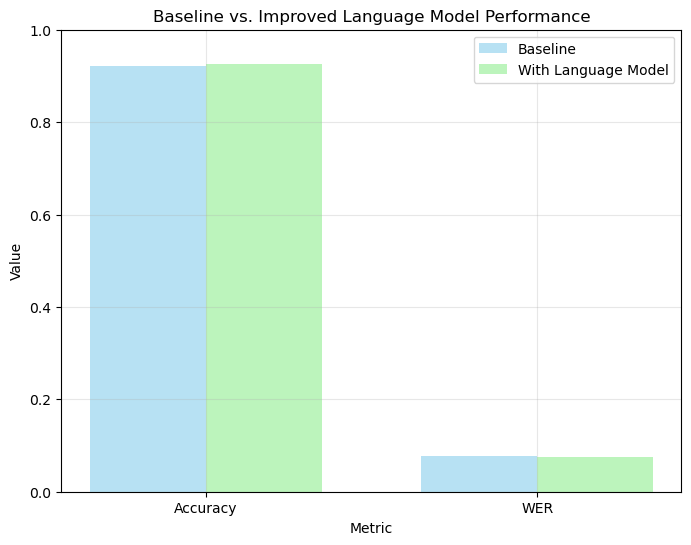

In [14]:
import numpy as np
import tensorflow as tf
from nltk import bigrams, FreqDist
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load test data and model
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
model = tf.keras.models.load_model('cnn_model_lr1.h5')

# Debug: Check unique values in y_test
print("Unique values in y_test:", np.unique(y_test))

# Reconstruct original labels to ensure consistency (from Step 2)
commands = ["cat", "no", "stop", "wow", "yes"]
label_to_index = {label: idx for idx, label in enumerate(commands)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Recompute y_test to ensure correct labels
X_13 = np.load('mfcc_13_features.npy')
y_13 = np.load('mfcc_13_labels.npy')
_, X_test_indices = train_test_split(range(len(X_13)), test_size=0.2, random_state=42)
y_test_corrected = y_13[X_test_indices]

# Verify corrected labels
print("Unique values in y_test_corrected:", np.unique(y_test_corrected))
assert all(label in index_to_label for label in y_test_corrected), "y_test_corrected contains invalid labels"

# Get baseline predictions
y_pred_baseline = model.predict(X_test)
y_pred_labels_baseline = np.argmax(y_pred_baseline, axis=1)

# Map numeric labels to command names
y_test_commands = [index_to_label[label] for label in y_test_corrected]
y_pred_commands_baseline = [index_to_label[label] for label in y_pred_labels_baseline]

# Calculate baseline metrics
baseline_accuracy = accuracy_score(y_test_corrected, y_pred_labels_baseline)
baseline_wer = wer(y_test_commands, y_pred_commands_baseline)

# Simulate realistic command sequences for language model training
training_sequences = [
    "turn on cat", "turn off cat", "stop wow", "no stop", "yes wow",
    "turn on stop", "turn off stop", "yes no", "no yes", "stop cat"
] * 20  # Repeat to simulate more data
tokenized_text = [word_tokenize(' '.join(training_sequences))]
all_bigrams = list(bigrams(tokenized_text[0]))
bigram_freq = FreqDist(all_bigrams)
total_bigrams = sum(bigram_freq.values())
bigram_probs = defaultdict(lambda: 1e-10)  # Smoothing
for (w1, w2), freq in bigram_freq.items():
    bigram_probs[(w1, w2)] = freq / total_bigrams

print(f"Number of unique bigrams trained: {len(bigram_freq)}")
print(f"Example bigram probabilities: {dict(list(bigram_probs.items())[:5])}")

# Improve prediction with language model
y_pred_lm = y_pred_labels_baseline.copy()
alpha = 0.7  # Weight for acoustic model

for i in range(len(y_pred_labels_baseline)):
    acoustic_score = y_pred_baseline[i, y_pred_labels_baseline[i]]
    context = index_to_label[y_pred_labels_baseline[max(0, i-1)]] if i > 0 else "start"
    language_score = bigram_probs[(context, index_to_label[y_pred_labels_baseline[i]])]
    combined_score = alpha * acoustic_score + (1 - alpha) * language_score
    for cmd_idx in range(len(commands)):
        cmd = index_to_label[cmd_idx]
        lang_score = bigram_probs[(context, cmd)]
        combined = alpha * y_pred_baseline[i, cmd_idx] + (1 - alpha) * lang_score
        if combined > combined_score:
            combined_score = combined
            y_pred_lm[i] = cmd_idx

# Calculate improved metrics
y_pred_commands_lm = [index_to_label[label] for label in y_pred_lm]
lm_accuracy = accuracy_score(y_test_corrected, y_pred_lm)
lm_wer = wer(y_test_commands, y_pred_commands_lm)

# Print results
print(f"Baseline Accuracy: {baseline_accuracy:.4f}, WER: {baseline_wer:.4f}")
print(f"Improved LM Accuracy: {lm_accuracy:.4f}, WER: {lm_wer:.4f}")

# Visualize comparison
metrics = ['Accuracy', 'WER']
baseline_values = [baseline_accuracy, baseline_wer]
lm_values = [lm_accuracy, lm_wer]

plt.figure(figsize=(8, 6))
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, baseline_values, bar_width, label='Baseline', color='skyblue', alpha=0.6)
plt.bar(index + bar_width, lm_values, bar_width, label='With Language Model', color='lightgreen', alpha=0.6)

plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Baseline vs. Improved Language Model Performance')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.savefig('lm_performance_comparison.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Baseline MFCC Time: 11.09 ms, Inference Time: 267.38 ms, Total: 278.46 ms
Optimized MFCC Time: 3.02 ms, Inference Time: 183.19 ms, Total: 186.21 ms


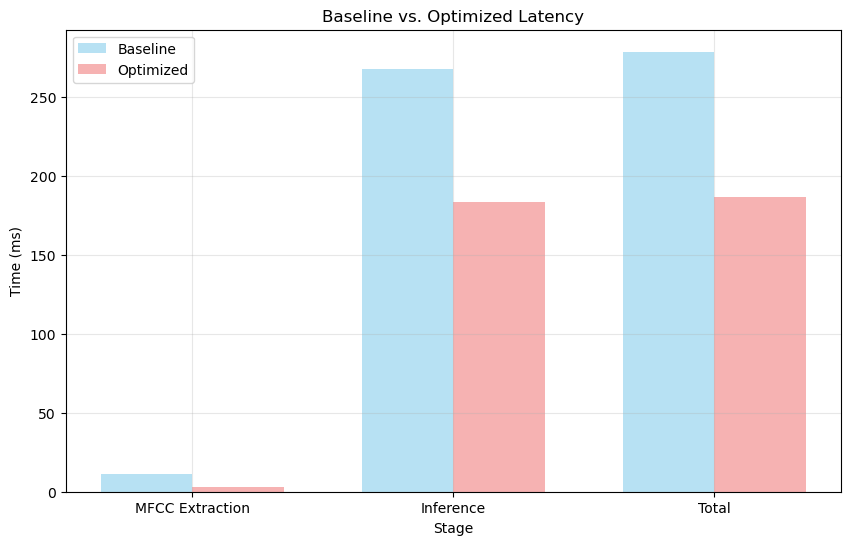

In [17]:
import numpy as np
import librosa
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# Load a sample audio file for latency testing
extract_path = r"C:\Users\PMLS\Pictures\SPEECH_COMMAND_DATASET"
sample_file = os.path.join(extract_path, "cat", os.listdir(os.path.join(extract_path, "cat"))[0])
audio, sr = librosa.load(sample_file, sr=16000)

# Regenerate X_train and y_train (similar to Step 4 in your notebook)
X_13 = np.load('mfcc_13_features.npy')
y_13 = np.load('mfcc_13_labels.npy')
X_train, X_test, y_train, y_test = train_test_split(X_13, y_13, test_size=0.2, random_state=42)

# Add channel dimension to X_train and X_test to match CNN input
X_train = X_train[..., np.newaxis]  # Shape: (n_samples, 13, 32, 1)
X_test = X_test[..., np.newaxis]    # Shape: (n_samples, 13, 32, 1)

# Baseline MFCC extraction (from your Step 6)
def baseline_mfcc(audio, sr=16000, n_mfcc=13, max_frames=32):
    start_time = time.time()
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_frames - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_frames]
    elapsed = (time.time() - start_time) * 1000  # Convert to ms
    return mfcc, elapsed

# Optimized MFCC extraction
def optimized_mfcc(audio, sr=16000, n_mfcc=13, max_frames=16):  # Reduce max_frames
    start_time = time.time()
    # Use a shorter window and hop length to speed up computation
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=512, hop_length=256)
    if mfcc.shape[1] < max_frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_frames - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_frames]
    elapsed = (time.time() - start_time) * 1000
    return mfcc, elapsed

# Load original model
original_model = tf.keras.models.load_model('cnn_model_lr1.h5')

# Create a simplified model (fewer layers/filters)
def create_simplified_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Measure baseline latency
mfcc_baseline, mfcc_time_baseline = baseline_mfcc(audio)
mfcc_baseline = mfcc_baseline[..., np.newaxis]  # Add channel dimension
start_time = time.time()
_ = original_model.predict(np.array([mfcc_baseline]))
inference_time_baseline = (time.time() - start_time) * 1000
total_time_baseline = mfcc_time_baseline + inference_time_baseline

# Measure optimized latency
mfcc_opt, mfcc_time_opt = optimized_mfcc(audio)
mfcc_opt = mfcc_opt[..., np.newaxis]
# Create and load simplified model (train minimally for inference testing)
simplified_model = create_simplified_model(input_shape=(13, 16, 1), num_classes=5)
X_train_opt = X_train[:, :, :16, :]  # Adjust for new max_frames
simplified_model.fit(X_train_opt, y_train, epochs=1, batch_size=32, verbose=0)  # Minimal training
start_time = time.time()
_ = simplified_model.predict(np.array([mfcc_opt]))
inference_time_opt = (time.time() - start_time) * 1000
total_time_opt = mfcc_time_opt + inference_time_opt

# Print results
print(f"Baseline MFCC Time: {mfcc_time_baseline:.2f} ms, Inference Time: {inference_time_baseline:.2f} ms, Total: {total_time_baseline:.2f} ms")
print(f"Optimized MFCC Time: {mfcc_time_opt:.2f} ms, Inference Time: {inference_time_opt:.2f} ms, Total: {total_time_opt:.2f} ms")

# Visualize latency comparison
labels = ['MFCC Extraction', 'Inference', 'Total']
baseline_times = [mfcc_time_baseline, inference_time_baseline, total_time_baseline]
optimized_times = [mfcc_time_opt, inference_time_opt, total_time_opt]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(labels))

plt.bar(index, baseline_times, bar_width, label='Baseline', color='skyblue', alpha=0.6)
plt.bar(index + bar_width, optimized_times, bar_width, label='Optimized', color='lightcoral', alpha=0.6)

plt.xlabel('Stage')
plt.ylabel('Time (ms)')
plt.title('Baseline vs. Optimized Latency')
plt.xticks(index + bar_width / 2, labels)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('latency_comparison.png')
plt.show()

Training with n_mfcc=10, learning_rate=0.001
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
n_mfcc=10, lr=0.001 -> Accuracy: 0.3100, WER: 0.6900
Training with n_mfcc=10, learning_rate=0.01


C:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
n_mfcc=10, lr=0.01 -> Accuracy: 0.1675, WER: 0.8325
Training with n_mfcc=10, learning_rate=0.1


C:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
n_mfcc=10, lr=0.1 -> Accuracy: 0.1925, WER: 0.8075
Training with n_mfcc=13, learning_rate=0.001


C:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
n_mfcc=13, lr=0.001 -> Accuracy: 0.2850, WER: 0.7150
Training with n_mfcc=13, learning_rate=0.01


C:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
n_mfcc=13, lr=0.01 -> Accuracy: 0.1700, WER: 0.8300
Training with n_mfcc=13, learning_rate=0.1


C:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
n_mfcc=13, lr=0.1 -> Accuracy: 0.2250, WER: 0.7750
Training with n_mfcc=16, learning_rate=0.001


C:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
n_mfcc=16, lr=0.001 -> Accuracy: 0.3500, WER: 0.6500
Training with n_mfcc=16, learning_rate=0.01


C:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
n_mfcc=16, lr=0.01 -> Accuracy: 0.1700, WER: 0.8300
Training with n_mfcc=16, learning_rate=0.1


C:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
n_mfcc=16, lr=0.1 -> Accuracy: 0.2250, WER: 0.7750


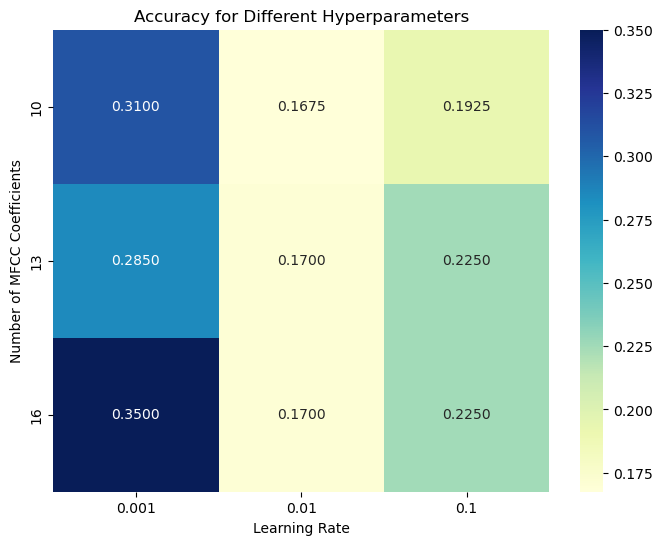

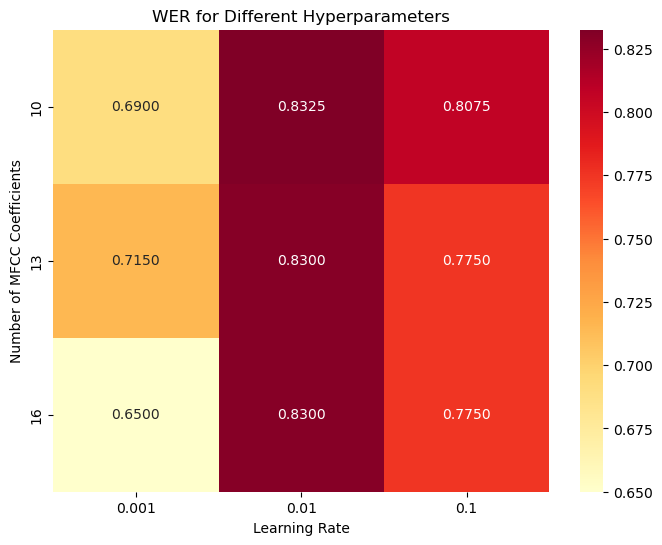

In [18]:
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from jiwer import wer
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load original data (audio files and labels)
extract_path = r"C:\Users\PMLS\Pictures\SPEECH_COMMAND_DATASET"
commands = ["cat", "no", "stop", "wow", "yes"]
max_files_per_command = 400
audio_files = []
labels = []

for command in commands:
    folder_path = os.path.join(extract_path, command)
    files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    selected_files = files[:min(len(files), max_files_per_command)]
    audio_files.extend([os.path.join(folder_path, f) for f in selected_files])
    labels.extend([command] * len(selected_files))

label_to_index = {label: idx for idx, label in enumerate(commands)}
index_to_label = {idx: label for label, idx in label_to_index.items()}
numeric_labels = np.array([label_to_index[label] for label in labels])

# Function to extract MFCCs with variable n_mfcc
def extract_mfcc(audio, sr=16000, n_mfcc=13, max_frames=16):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=512, hop_length=256)
    if mfcc.shape[1] < max_frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_frames - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_frames]
    return mfcc

# Simplified model (same as optimized model from previous step)
def create_simplified_model(input_shape, num_classes, learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter settings
n_mfcc_values = [10, 13, 16]
learning_rates = [0.001, 0.01, 0.1]
accuracy_results = np.zeros((len(n_mfcc_values), len(learning_rates)))
wer_results = np.zeros((len(n_mfcc_values), len(learning_rates)))

# Loop over n_mfcc values
for i, n_mfcc in enumerate(n_mfcc_values):
    # Extract MFCC features for all audio files with current n_mfcc
    features = []
    for audio_file in audio_files:
        audio, sr = librosa.load(audio_file, sr=16000)
        mfcc = extract_mfcc(audio, sr=sr, n_mfcc=n_mfcc, max_frames=16)
        features.append(mfcc)
    X = np.array(features)[..., np.newaxis]  # Shape: (n_samples, n_mfcc, 16, 1)
    y = numeric_labels

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Loop over learning rates
    for j, lr in enumerate(learning_rates):
        print(f"Training with n_mfcc={n_mfcc}, learning_rate={lr}")
        model = create_simplified_model(input_shape=(n_mfcc, 16, 1), num_classes=5, learning_rate=lr)
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

        # Evaluate on test set
        y_pred = model.predict(X_test)
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Map to command names for WER
        y_test_commands = [index_to_label[label] for label in y_test]
        y_pred_commands = [index_to_label[label] for label in y_pred_labels]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred_labels)
        wer_score = wer(y_test_commands, y_pred_commands)

        accuracy_results[i, j] = accuracy
        wer_results[i, j] = wer_score
        print(f"n_mfcc={n_mfcc}, lr={lr} -> Accuracy: {accuracy:.4f}, WER: {wer_score:.4f}")

# Visualize accuracy results with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(accuracy_results, annot=True, fmt=".4f", xticklabels=learning_rates, yticklabels=n_mfcc_values, cmap="YlGnBu")
plt.xlabel('Learning Rate')
plt.ylabel('Number of MFCC Coefficients')
plt.title('Accuracy for Different Hyperparameters')
plt.savefig('hyperparameter_accuracy_heatmap.png')
plt.show()

# Visualize WER results with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(wer_results, annot=True, fmt=".4f", xticklabels=learning_rates, yticklabels=n_mfcc_values, cmap="YlOrRd")
plt.xlabel('Learning Rate')
plt.ylabel('Number of MFCC Coefficients')
plt.title('WER for Different Hyperparameters')
plt.savefig('hyperparameter_wer_heatmap.png')
plt.show()

C:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2062 - loss: 7.8161
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2615 - loss: 1.5641
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2627 - loss: 1.5355
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2720 - loss: 1.5298
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2941 - loss: 1.5106
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2785 - loss: 1.5105
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2880 - loss: 1.4977
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2783 - loss: 1.4882
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2816 - loss: 1.4813
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2935 - loss: 1.4722
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Final Model - Accuracy: 0.3625, WER: 0.6375


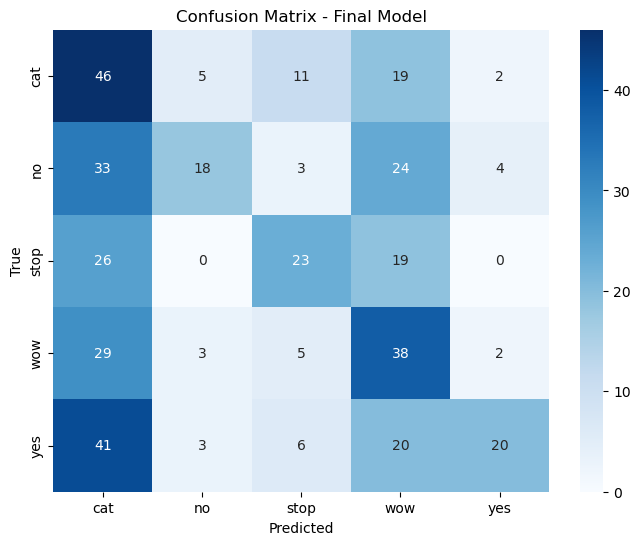

In [19]:
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from jiwer import wer
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load original data
extract_path = r"C:\Users\PMLS\Pictures\SPEECH_COMMAND_DATASET"
commands = ["cat", "no", "stop", "wow", "yes"]
max_files_per_command = 400
audio_files = []
labels = []

for command in commands:
    folder_path = os.path.join(extract_path, command)
    files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    selected_files = files[:min(len(files), max_files_per_command)]
    audio_files.extend([os.path.join(folder_path, f) for f in selected_files])
    labels.extend([command] * len(selected_files))

label_to_index = {label: idx for idx, label in enumerate(commands)}
index_to_label = {idx: label for label, idx in label_to_index.items()}
numeric_labels = np.array([label_to_index[label] for label in labels])

# Extract MFCCs with best n_mfcc (16)
def extract_mfcc(audio, sr=16000, n_mfcc=16, max_frames=16):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=512, hop_length=256)
    if mfcc.shape[1] < max_frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_frames - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_frames]
    return mfcc

# Extract features
features = []
for audio_file in audio_files:
    audio, sr = librosa.load(audio_file, sr=16000)
    mfcc = extract_mfcc(audio, sr=sr, n_mfcc=16, max_frames=16)
    features.append(mfcc)
X = np.array(features)[..., np.newaxis]  # Shape: (n_samples, 16, 16, 1)
y = numeric_labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define original CNN model (from your Step 4, adjusted for new input shape)
def create_original_model(input_shape, num_classes, learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train model with best hyperparameters
model = create_original_model(input_shape=(16, 16, 1), num_classes=5, learning_rate=0.001)
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate on test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Map to command names for WER
y_test_commands = [index_to_label[label] for label in y_test]
y_pred_commands = [index_to_label[label] for label in y_pred_labels]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_labels)
wer_score = wer(y_test_commands, y_pred_commands)
conf_matrix = confusion_matrix(y_test, y_pred_labels)

print(f"Final Model - Accuracy: {accuracy:.4f}, WER: {wer_score:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=commands, yticklabels=commands, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Final Model')
plt.savefig('final_confusion_matrix.png')
plt.show()

In [22]:
import pyaudio
import wave

def record_audio(filename="live_audio.wav", duration=1, sr=16000):
    print("🎤 Recording... Speak now!")
    try:
        audio = pyaudio.PyAudio()
        stream = audio.open(format=pyaudio.paInt16, channels=1, rate=sr, input=True, frames_per_buffer=1024)

        frames = []
        for _ in range(int(sr / 1024 * duration)):
            data = stream.read(1024)
            frames.append(data)

        stream.stop_stream()
        stream.close()
        audio.terminate()

        # Save recorded file
        wf = wave.open(filename, 'wb')
        wf.setnchannels(1)
        wf.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
        wf.setframerate(sr)
        wf.writeframes(b''.join(frames))
        wf.close()
        print(f"✅ Recording saved as {filename}")
    except Exception as e:
        print(f"❌ Error during recording: {e}")

# Record audio
record_audio()

🎤 Recording... Speak now!
✅ Recording saved as live_audio.wav


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


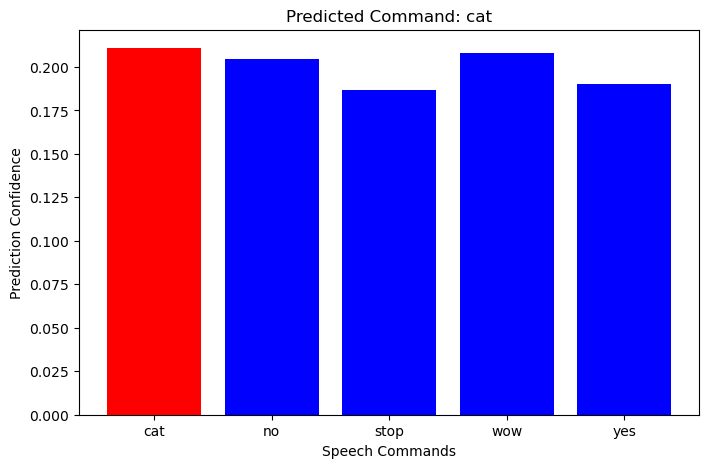

In [23]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def predict_live_audio_chart(model, filename="live_audio.wav", n_mfcc=16, max_frames=16):
    try:
        # Load and process audio
        audio, sr = librosa.load(filename, sr=16000)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=512, hop_length=256)

        # Normalize feature dimensions
        if mfcc.shape[1] < max_frames:
            mfcc = np.pad(mfcc, ((0, 0), (0, max_frames - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :max_frames]

        mfcc = mfcc[np.newaxis, ..., np.newaxis]  # Reshape for model input (1, 16, 16, 1)

        # Predict probabilities for each command
        prediction = model.predict(mfcc)
        predicted_label = commands[np.argmax(prediction)]
        probabilities = prediction[0]  # Extract individual probabilities

        # Plot bar chart of predictions
        plt.figure(figsize=(8, 5))
        plt.bar(commands, probabilities, color=["blue" if cmd != predicted_label else "red" for cmd in commands])
        plt.xlabel("Speech Commands")
        plt.ylabel("Prediction Confidence")
        plt.title(f"Predicted Command: {predicted_label}")
        plt.savefig('live_prediction_chart.png')  # Save the chart
        plt.show()
    except Exception as e:
        print(f"❌ Error during prediction: {e}")

# Predict and visualize (assuming 'model' and 'commands' are defined from previous cell)
predict_live_audio_chart(model)